# **2110433 - Computer Vision (2024/2)**
#**Lab 9 - Modern Object Detection [Homework]** <br>
In this lab, we will learn how to use MMDetection to perform object detection in the provided real world dataset using PyTorch. This notebook includes both coding and written questions. Please hand in this notebook file with all outputs and your answer.

**Collaboration is encouraged in this course.** You must turn in your own write ups of all problems. If you collaborate with others, you must put the names and ids of the students you worked with in below block.

Collaboration List:
- ...
- ...


# Assignment 1 : Parasite Detection
![alt text](https://icip2022challenge.piclab.ai/wp-content/uploads/2022/01/parasite_egg_11_with_size.png)

In this assignment you have to replace YOUR_STUDENT_ID_WITH21 variable with your student id (in integer). There will be 2 sets of data: train and test

By using the knowledge from the lab and lecture, you have to train object detection model and tested on unknown label dataset!



Scoreboard URL : https://www.piclab.ai/classes/cv2024/lab9/scoreboard

### Hints
- The parasite dataset was created using COCO dataset format
- If you use MMDetection, the dataset is ready to use
- If you want to use Ultralytics, you have to format to YOLO dataset format (use Fiftyone!)


## GPU Status Check

In [ ]:
!nvidia-smi

Thu Mar 27 10:52:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Download and inspect parasite dataset

In [ ]:
!pip install --upgrade gdown
!gdown https://drive.google.com/uc?id=1RVluBzZvJ8mWwA5AuB2PklbaoK60uPMF
!gdown https://drive.google.com/uc?id=1kvBxmC1o0vE2ef2CJqhLaj9V4TD72oW3
!unzip parasite_train.zip
!unzip parasite_test.zip

Downloading...
From (original): https://drive.google.com/uc?id=1RVluBzZvJ8mWwA5AuB2PklbaoK60uPMF
From (redirected): https://drive.google.com/uc?id=1RVluBzZvJ8mWwA5AuB2PklbaoK60uPMF&confirm=t&uuid=99907328-07bf-46f9-9b75-a91ba3e6e5d8
To: /content/parasite_test.zip
100% 142M/142M [00:01<00:00, 140MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1kvBxmC1o0vE2ef2CJqhLaj9V4TD72oW3
From (redirected): https://drive.google.com/uc?id=1kvBxmC1o0vE2ef2CJqhLaj9V4TD72oW3&confirm=t&uuid=c10f8c1a-33fe-47d5-bfcb-dac52f5aaf47
To: /content/parasite_train.zip
100% 715M/715M [00:08<00:00, 81.6MB/s]
Archive:  parasite_train.zip
   creating: parasite_train/
  inflating: parasite_train/labels.json  
   creating: parasite_train/data/
  inflating: parasite_train/data/Hymenolepis nana_0371.jpg  
  inflating: __MACOSX/parasite_train/data/._Hymenolepis nana_0371.jpg  
  inflating: parasite_train/data/Enterobius vermicularis_0966.jpg  
  inflating: __MACOSX/parasite_train/data/._Enterobius verm

## Your model description goes here: ###
ใช้ YOLO V8m โดย train ด้วยการ freeze weights ของ YOLO V8m จากนั้นเมื่อได้ model มาแล้วก็นำไป fine tune ต่อด้วยการ freeze weight แค่ layer ช่วงแรก

### Dataset Exploration
We will use pycocotools to explore this dataset.

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
trainLabelFile='parasite_train/labels.json'
# initialize COCO api for instance annotations
trainCOCOBinding = COCO(trainLabelFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


COCO categories: 
Capillaria philippinensis, Enterobius vermicularis, Hymenolepis diminuta, Hymenolepis nana, Paragonimus spp

Image Data >> {'id': 109, 'file_name': 'Hymenolepis nana_0541.jpg', 'height': 1080, 'width': 1920, 'license': None, 'coco_url': None}
Box Data [{'id': 109, 'image_id': 109, 'category_id': 3, 'bbox': [868.0, 489.0, 130.0, 119.0], 'area': 15470.0, 'iscrowd': 0}]


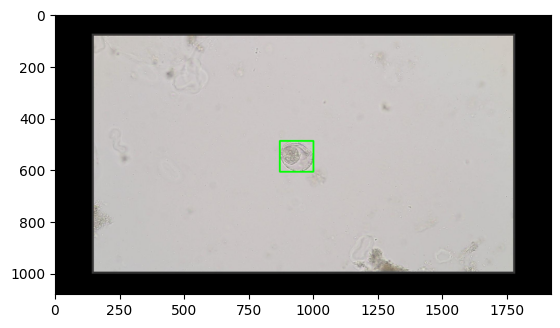

In [ ]:
#display COCO categories and supercategories
cats = trainCOCOBinding.loadCats(trainCOCOBinding.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(', '.join(nms)))

# get all images containing given categories, select one at random
catIds = trainCOCOBinding.getCatIds(catNms=['Hymenolepis diminuta',]);
imgIds = trainCOCOBinding.getImgIds(catIds=catIds );

randomImgId = np.random.randint(0,len(imgIds))
sampleImageData = trainCOCOBinding.loadImgs(randomImgId)[0]

print('Image Data >>', sampleImageData)

sampleImage = cv2.imread('parasite_train/data/'+sampleImageData['file_name'])

annIds = trainCOCOBinding.getAnnIds(imgIds=randomImgId, iscrowd=None)
boxes = trainCOCOBinding.loadAnns(annIds)
print('Box Data', boxes)

for box in boxes:
  x,y,w,h = box['bbox']
  cv2.rectangle(sampleImage, (int(x), int(y)), (int(x+w), int(y+h)), (0,255,0), 5)

sampleImage = cv2.cvtColor(sampleImage, cv2.COLOR_BGR2RGB)

plt.imshow(sampleImage)
plt.show()

In [ ]:
# Define paths
coco_file = trainLabelFile
output_dir = 'yolo_dataset'
img_dir = '/content/parasite_train/data'  # Original images location

In [ ]:
import os

# Create output directories
labels_dir = os.path.join(output_dir, 'labels')
images_dir = os.path.join(output_dir, 'images')
os.makedirs(labels_dir, exist_ok=True)
os.makedirs(images_dir, exist_ok=True)

In [ ]:
import json

# Load COCO file
with open(coco_file, 'r') as f:
    coco_data = json.load(f)

In [ ]:
# Show available categories
categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
print(f"Categories: {categories}")

Categories: {0: 'Capillaria philippinensis', 1: 'Enterobius vermicularis', 2: 'Hymenolepis diminuta', 3: 'Hymenolepis nana', 4: 'Paragonimus spp'}


In [ ]:
# Create a dictionary to map image_id to filename and size
images_info = {}
for img in coco_data['images']:
    images_info[img['id']] = {
        'file_name': img['file_name'],
        'width': img['width'],
        'height': img['height']
    }

In [ ]:
import shutil

# Process annotations
annotations = {}
for ann in coco_data['annotations']:
    image_id = ann['image_id']

    if image_id not in annotations:
        annotations[image_id] = []

    category_id = ann['category_id']
    x, y, w, h = ann['bbox']

    # Convert to YOLO format (normalized)
    img_width = images_info[image_id]['width']
    img_height = images_info[image_id]['height']

    # Calculate center point and normalized dimensions
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    width = w / img_width
    height = h / img_height

    annotations[image_id].append(f"{category_id} {x_center} {y_center} {width} {height}")

In [ ]:
# Write annotations to files and copy images
for image_id, anno_list in annotations.items():
    # Get image filename without extension
    img_filename = images_info[image_id]['file_name']
    base_filename = os.path.splitext(img_filename)[0]

    # Create label file
    with open(os.path.join(labels_dir, f"{base_filename}.txt"), 'w') as f:
        f.write('\n'.join(anno_list))

    # Copy image
    src_path = os.path.join(img_dir, img_filename)
    if os.path.exists(src_path):
        shutil.copy(src_path, os.path.join(images_dir, img_filename))


In [ ]:
print(f"Converted {len(annotations)} annotations to YOLO format")
print(f"Labels saved to {labels_dir}")
print(f"Images copied to {images_dir}")

Converted 1000 annotations to YOLO format
Labels saved to yolo_dataset/labels
Images copied to yolo_dataset/images


In [ ]:
# Visualization of a sample image with annotations for verification
def visualize_sample(n=1):
    # Randomly select n images
    sample_image_ids = list(annotations.keys())[:n]

    for img_id in sample_image_ids:
        img_info = images_info[img_id]
        img_file = img_info['file_name']
        img_path = os.path.join(images_dir, img_file)

        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get original annotations
        coco_anns = [ann for ann in coco_data['annotations'] if ann['image_id'] == img_id]

        # Draw COCO annotations
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('COCO Annotations')

        for ann in coco_anns:
            x, y, w, h = [int(c) for c in ann['bbox']]
            cat_id = ann['category_id']
            cat_name = categories[cat_id]

            rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x, y-10, f"{cat_name} (id:{cat_id})", color='white',
                    bbox=dict(facecolor='red', alpha=0.5))

        # Draw YOLO annotations converted back to pixel coordinates
        plt.subplot(1, 2, 2)
        plt.imshow(img)
        plt.title('YOLO Annotations (Converted Back)')

        # Read YOLO annotations
        yolo_label_path = os.path.join(labels_dir, f"{os.path.splitext(img_file)[0]}.txt")
        with open(yolo_label_path, 'r') as f:
            yolo_annotations = f.readlines()

        for ann in yolo_annotations:
            parts = ann.strip().split()
            if len(parts) == 5:
                cat_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:5])

                # Convert normalized coordinates back to pixels
                img_width, img_height = img_info['width'], img_info['height']
                x_center *= img_width
                y_center *= img_height
                width *= img_width
                height *= img_height

                # Convert center coordinates to top-left for rectangle
                x = int(x_center - width/2)
                y = int(y_center - height/2)
                w = int(width)
                h = int(height)

                cat_name = categories[cat_id]

                rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
                plt.gca().add_patch(rect)
                plt.text(x, y-10, f"{cat_name} (id:{cat_id})", color='white',
                        bbox=dict(facecolor='green', alpha=0.5))

        plt.tight_layout()
        plt.show()


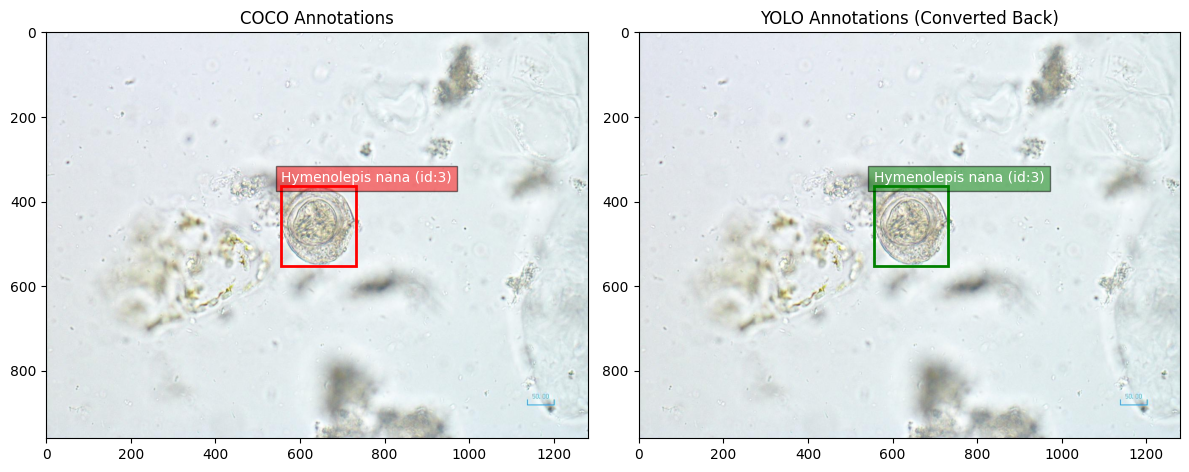

In [ ]:
visualize_sample()

In [ ]:
import random
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [ ]:
import os
import yaml
import json
import shutil

def create_dataset_yaml(dataset_dir='/content/yolo_dataset'):
    # Check if train/val directories already exist
    train_dir = os.path.join(dataset_dir, 'images/train')
    val_dir = os.path.join(dataset_dir, 'images/val')

    if os.path.exists(train_dir) and os.path.exists(val_dir):
        print("Train/val directories already exist")
    else:
        # Define the paths
        images_dir = os.path.join(dataset_dir, 'images')
        labels_dir = os.path.join(dataset_dir, 'labels')

        # Create train/val folders if they don't exist
        train_dir = os.path.join(dataset_dir, 'images/train')
        val_dir = os.path.join(dataset_dir, 'images/val')
        train_labels_dir = os.path.join(dataset_dir, 'labels/train')
        val_labels_dir = os.path.join(dataset_dir, 'labels/val')

        for d in [train_dir, val_dir, train_labels_dir, val_labels_dir]:
            os.makedirs(d, exist_ok=True)

        # First, list all the images
        images = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]
        total_images = len(images)

        # Shuffle and split
        random.seed(42)  # For reproducibility
        random.shuffle(images)

        split_idx = int(0.8 * total_images)  # 80% for training, 20% for validation
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        print(f"Total images: {total_images}")
        print(f"Training images: {len(train_images)}")
        print(f"Validation images: {len(val_images)}")

        # Copy (not move) files to train/val folders
        for img in train_images:
            # Copy image
            shutil.copy(os.path.join(images_dir, img), os.path.join(train_dir, img))

            # Copy corresponding label
            label_name = os.path.splitext(img)[0] + '.txt'
            label_path = os.path.join(labels_dir, label_name)
            if os.path.exists(label_path):
                shutil.copy(label_path, os.path.join(train_labels_dir, label_name))

        for img in val_images:
            # Copy image
            shutil.copy(os.path.join(images_dir, img), os.path.join(val_dir, img))

            # Copy corresponding label
            label_name = os.path.splitext(img)[0] + '.txt'
            label_path = os.path.join(labels_dir, label_name)
            if os.path.exists(label_path):
                shutil.copy(label_path, os.path.join(val_labels_dir, label_name))

    # Load class names from COCO file
    with open('/content/parasite_train/labels.json', 'r') as f:
        coco_data = json.load(f)

    class_names = [cat['name'] for cat in coco_data['categories']]
    num_classes = len(class_names)

    # Create the dataset.yaml content
    yaml_content = {
        'path': os.path.abspath(dataset_dir),
        'train': 'images/train',
        'val': 'images/val',
        'nc': num_classes,
        'names': class_names
    }

    # Write to file
    yaml_path = os.path.join(dataset_dir, 'dataset.yaml')
    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_content, f, default_flow_style=False)

    print(f"Created dataset config at {yaml_path}")
    print(f"Classes: {class_names}")
    return yaml_path

In [ ]:
# Create dataset.yaml
yaml_path = create_dataset_yaml()

Total images: 1000
Training images: 800
Validation images: 200
Created dataset config at /content/yolo_dataset/dataset.yaml
Classes: ['Capillaria philippinensis', 'Enterobius vermicularis', 'Hymenolepis diminuta', 'Hymenolepis nana', 'Paragonimus spp']


### Training

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from ultralytics import YOLO

In [ ]:
import torch
import random


model = YOLO('yolov8m.pt')

results = model.train(
    data='/content/yolo_dataset/dataset.yaml',
    epochs=20,
    imgsz=640,
    batch=16,
    name='parasite_detection',
    seed=42,
    save=True,

    lr0=0.0005,
    lrf=0.01,

    freeze=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],

    # Augmentations
    flipud=0.5,        # Flip up-down (50% probability)
    fliplr=0.5,        # Flip left-right (50% probability)
    mosaic=1.0,        # Mosaic augmentation (100% probability)
    mixup=0.15,        # Mixup augmentation (15% probability)
    copy_paste=0.1,    # Copy-paste augmentation (10% probability)
    degrees=10.0,      # Rotate ±10 degrees
    translate=0.1,     # Translate ±10%
    scale=0.5,         # Scale from 50% to 150%
    shear=2.0,         # Shear ±2 degrees
    perspective=0.001, # Perspective distortion
    hsv_h=0.015,       # Hue ±1.5%
    hsv_s=0.7,         # Saturation ±70%
    hsv_v=0.4,         # Value (brightness) ±40%
)

Ultralytics 8.3.97 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/yolo_dataset/dataset.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=parasite_detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop

train: Scanning /content/yolo_dataset/labels/train... 800 images, 0 backgrounds, 0 corrupt: 100%|██████████| 800/800 [00:02<00:00, 300.65it/s]


train: New cache created: /content/yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/yolo_dataset/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 257.43it/s]

val: New cache created: /content/yolo_dataset/labels/val.cache


Plotting labels to runs/detect/parasite_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/parasite_detection
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.74G      1.215       3.43      1.197         44        640: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]

                   all        200        200      0.623      0.723      0.782       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.49G      1.115      1.352      1.164         31        640: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]

                   all        200        200      0.766      0.889      0.897      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.54G      1.142      1.096      1.211         35        640: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]

                   all        200        200      0.908      0.843       0.93      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.59G      1.123     0.9572      1.222         30        640: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]

                   all        200        200      0.869      0.915      0.973      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.64G       1.12     0.9683      1.192         33        640: 100%|██████████| 50/50 [00:41<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        200        200       0.94      0.955      0.987      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.69G       1.13     0.8768      1.218         28        640: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]

                   all        200        200       0.92      0.927      0.972       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.73G      1.107      0.783      1.174         30        640: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]

                   all        200        200      0.949      0.947      0.986       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.78G      1.073     0.7832      1.191         24        640: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]

                   all        200        200      0.916      0.948      0.979      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.83G      1.048     0.7188      1.154         40        640: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]

                   all        200        200       0.95      0.968      0.988      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.88G      1.081     0.7117      1.163         30        640: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]

                   all        200        200      0.954       0.94      0.981      0.703


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.93G     0.8187     0.5297      1.069         16        640: 100%|██████████| 50/50 [00:49<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

                   all        200        200      0.944      0.965       0.99      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.97G     0.8219     0.4977       1.07         16        640: 100%|██████████| 50/50 [00:39<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]

                   all        200        200      0.982      0.972      0.993      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.02G     0.7974      0.466      1.063         16        640: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]

                   all        200        200      0.939      0.959      0.978      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      5.07G     0.7972     0.4426       1.05         16        640: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]

                   all        200        200      0.967      0.955       0.99      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      5.12G     0.7889     0.4459      1.054         16        640: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        200        200       0.95      0.976      0.988      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      5.17G     0.7976     0.4267      1.046         16        640: 100%|██████████| 50/50 [00:37<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]

                   all        200        200      0.974      0.989      0.994      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      5.22G       0.76     0.4083      1.027         16        640: 100%|██████████| 50/50 [00:39<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]

                   all        200        200      0.982      0.989      0.995      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      5.27G      0.766     0.3988      1.027         16        640: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        200        200      0.991       0.99      0.995      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      5.31G     0.7562      0.384       1.01         16        640: 100%|██████████| 50/50 [00:42<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]

                   all        200        200      0.983      0.992      0.995      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      5.85G     0.7477      0.382      1.021         16        640: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]

                   all        200        200      0.978      0.995      0.995      0.713



20 epochs completed in 0.293 hours.
Optimizer stripped from runs/detect/parasite_detection/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/parasite_detection/weights/best.pt, 52.0MB

Validating runs/detect/parasite_detection/weights/best.pt...
Ultralytics 8.3.97 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,655 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


                   all        200        200      0.991      0.989      0.995      0.773
Capillaria philippinensis         44         44          1      0.953      0.994      0.747
Enterobius vermicularis         36         36          1      0.992      0.995      0.779
  Hymenolepis diminuta         48         48      0.997          1      0.995      0.776
      Hymenolepis nana         44         44      0.979          1      0.995      0.766
       Paragonimus spp         28         28      0.981          1      0.995      0.797
Speed: 0.2ms preprocess, 8.5ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/parasite_detection


In [ ]:
model = YOLO('runs/detect/parasite_detection/weights/best.pt')

results = model.train(
    data='/content/yolo_dataset/dataset.yaml',
    epochs=30,
    imgsz=640,
    batch=16,
    name='parasite_detection',
    seed=42,
    save=True,

    lr0=0.0005,
    lrf=0.01,

    # Regularization parameters
    weight_decay=0.0005,  # Increase L2 regularization

    freeze=[0, 1, 2, 3, 4],

    # Augmentations
    flipud=0.5,        # Flip up-down (50% probability)
    fliplr=0.5,        # Flip left-right (50% probability)
    mosaic=1.0,        # Mosaic augmentation (100% probability)
    mixup=0.15,        # Mixup augmentation (15% probability)
    copy_paste=0.1,    # Copy-paste augmentation (10% probability)
    degrees=10.0,      # Rotate ±10 degrees
    translate=0.1,     # Translate ±10%
    scale=0.5,         # Scale from 50% to 150%
    shear=2.0,         # Shear ±2 degrees
    perspective=0.001, # Perspective distortion
    hsv_h=0.015,       # Hue ±1.5%
    hsv_s=0.7,         # Saturation ±70%
    hsv_v=0.4,         # Value (brightness) ±40%
)

Ultralytics 8.3.97 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=runs/detect/parasite_detection/weights/best.pt, data=/content/yolo_dataset/dataset.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=parasite_detection2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=[0, 1, 2, 3, 4], multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

train: Scanning /content/yolo_dataset/labels/train.cache... 800 images, 0 backgrounds, 0 corrupt: 100%|██████████| 800/800 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/yolo_dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/parasite_detection2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/parasite_detection2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.11G      1.069     0.7085      1.159         44        640: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]

                   all        200        200      0.865      0.896      0.922      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      5.54G      1.029       0.71      1.145         31        640: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]

                   all        200        200      0.875      0.875      0.945      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      5.54G      1.086     0.8261      1.184         35        640: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]

                   all        200        200      0.804      0.794      0.863        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      5.54G      1.079     0.8022      1.207         30        640: 100%|██████████| 50/50 [00:53<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.68s/it]

                   all        200        200      0.896      0.851       0.95       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      5.54G      1.064     0.7831      1.172         33        640: 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        200        200      0.913      0.895       0.96      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      5.54G      1.058      0.735      1.196         28        640: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]

                   all        200        200       0.95      0.933      0.974      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      5.54G      1.061     0.7131      1.162         30        640: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]

                   all        200        200      0.991      0.938      0.992      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.54G      1.042     0.6872      1.172         24        640: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]

                   all        200        200      0.925      0.948      0.975      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      5.54G      1.026     0.6484      1.142         40        640: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


                   all        200        200      0.895      0.913      0.964      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      5.54G      1.029     0.6539      1.137         30        640: 100%|██████████| 50/50 [00:54<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.61s/it]

                   all        200        200      0.964      0.995      0.992      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      5.54G      1.045     0.6652       1.16         32        640: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.33s/it]

                   all        200        200      0.936      0.967      0.987      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      5.56G       1.06     0.6497      1.167         35        640: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]

                   all        200        200      0.946      0.987      0.989      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      5.56G      1.011      0.637      1.145         33        640: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]

                   all        200        200      0.953      0.963      0.987      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      5.56G     0.9909     0.6061      1.127         33        640: 100%|██████████| 50/50 [00:41<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]

                   all        200        200      0.967      0.983      0.993      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.62G      1.022     0.6068       1.15         31        640: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.14s/it]

                   all        200        200       0.95      0.971      0.988      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.62G     0.9938     0.5878       1.13         44        640: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]

                   all        200        200      0.985          1      0.993      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.69G     0.9933     0.5643      1.116         36        640: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]

                   all        200        200      0.977      0.983      0.994      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.75G     0.9873     0.5685      1.114         32        640: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]

                   all        200        200      0.979      0.984      0.995      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.75G     0.9704     0.5715      1.111         29        640: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]

                   all        200        200      0.972      0.988      0.994      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.81G     0.9752     0.5709      1.126         28        640: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]

                   all        200        200      0.981          1      0.994      0.751


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.81G     0.7648     0.4129      1.033         16        640: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]

                   all        200        200      0.961      0.982      0.991      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.81G     0.7367     0.4023      1.017         16        640: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]

                   all        200        200      0.987      0.995      0.995      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.88G      0.725     0.3823      1.011         16        640: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]

                   all        200        200       0.99      0.999      0.995      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.88G     0.7142     0.3582     0.9913         16        640: 100%|██████████| 50/50 [00:38<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]

                   all        200        200      0.982      0.985      0.994      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.88G     0.7121       0.35      1.003         16        640: 100%|██████████| 50/50 [00:38<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]

                   all        200        200       0.99      0.991      0.995      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.88G     0.6867     0.3405     0.9901         16        640: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]

                   all        200        200      0.993      0.995      0.995      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.88G     0.6951     0.3369     0.9773         16        640: 100%|██████████| 50/50 [00:38<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.02s/it]

                   all        200        200      0.988      0.995      0.995       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.88G     0.6951      0.334     0.9898         16        640: 100%|██████████| 50/50 [00:38<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        200        200      0.993      0.997      0.995      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      5.88G     0.6764      0.323      0.984         16        640: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]

                   all        200        200       0.99      0.995      0.995      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.88G     0.6706     0.3221     0.9809         16        640: 100%|██████████| 50/50 [00:47<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]

                   all        200        200       0.99      0.994      0.995      0.769



30 epochs completed in 0.449 hours.
Optimizer stripped from runs/detect/parasite_detection2/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/parasite_detection2/weights/best.pt, 52.0MB

Validating runs/detect/parasite_detection2/weights/best.pt...
Ultralytics 8.3.97 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,655 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:16<00:00,  2.29s/it]


                   all        200        200      0.988      0.995      0.995      0.779
Capillaria philippinensis         44         44      0.992      0.977      0.994       0.74
Enterobius vermicularis         36         36      0.995          1      0.995      0.821
  Hymenolepis diminuta         48         48       0.99          1      0.995      0.801
      Hymenolepis nana         44         44      0.991          1      0.995      0.779
       Paragonimus spp         28         28      0.974          1      0.995      0.757
Speed: 0.3ms preprocess, 10.2ms inference, 0.0ms loss, 6.2ms postprocess per image
Results saved to runs/detect/parasite_detection2


In [ ]:
metrics = model.val()

print(f"\nValidation metrics:")
print(f"mAP50-95: {metrics.box.map}")
print(f"mAP50: {metrics.box.map50}")
print(f"Precision: {metrics.box.p}")
print(f"Recall: {metrics.box.r}")

Ultralytics 8.3.97 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,655 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/yolo_dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:16<00:00,  1.26s/it]


                   all        200        200      0.989      0.995      0.995      0.776
Capillaria philippinensis         44         44      0.992      0.977      0.994      0.732
Enterobius vermicularis         36         36      0.995          1      0.995       0.82
  Hymenolepis diminuta         48         48       0.99          1      0.995      0.803
      Hymenolepis nana         44         44      0.992          1      0.995      0.777
       Paragonimus spp         28         28      0.976          1      0.995      0.747
Speed: 2.1ms preprocess, 17.5ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/parasite_detection22

Validation metrics:
mAP50-95: 0.7758559721612793
mAP50: 0.9948260869565217
Precision: [    0.99208     0.99527     0.99012     0.99157      0.9762]
Recall: [    0.97727           1           1           1           1]


In [ ]:
def run_inference(img_path):
    # Get predictions
    results = model.predict(img_path, conf=0.25, save=True)

    # Process results
    for r in results:
        # Get the path to the saved image
        image_path = os.path.join(r.save_dir, os.path.basename(img_path))

        # Load and show the image using matplotlib instead of IPython display
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img = mpimg.imread(image_path)
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predictions for {os.path.basename(img_path)}")
        plt.show()

        # Print detections
        boxes = r.boxes
        for box in boxes:
            cls = int(box.cls[0])
            cls_name = model.names[cls]
            conf = float(box.conf[0])
            print(f"Detected: {cls_name} with confidence {conf:.2f}")

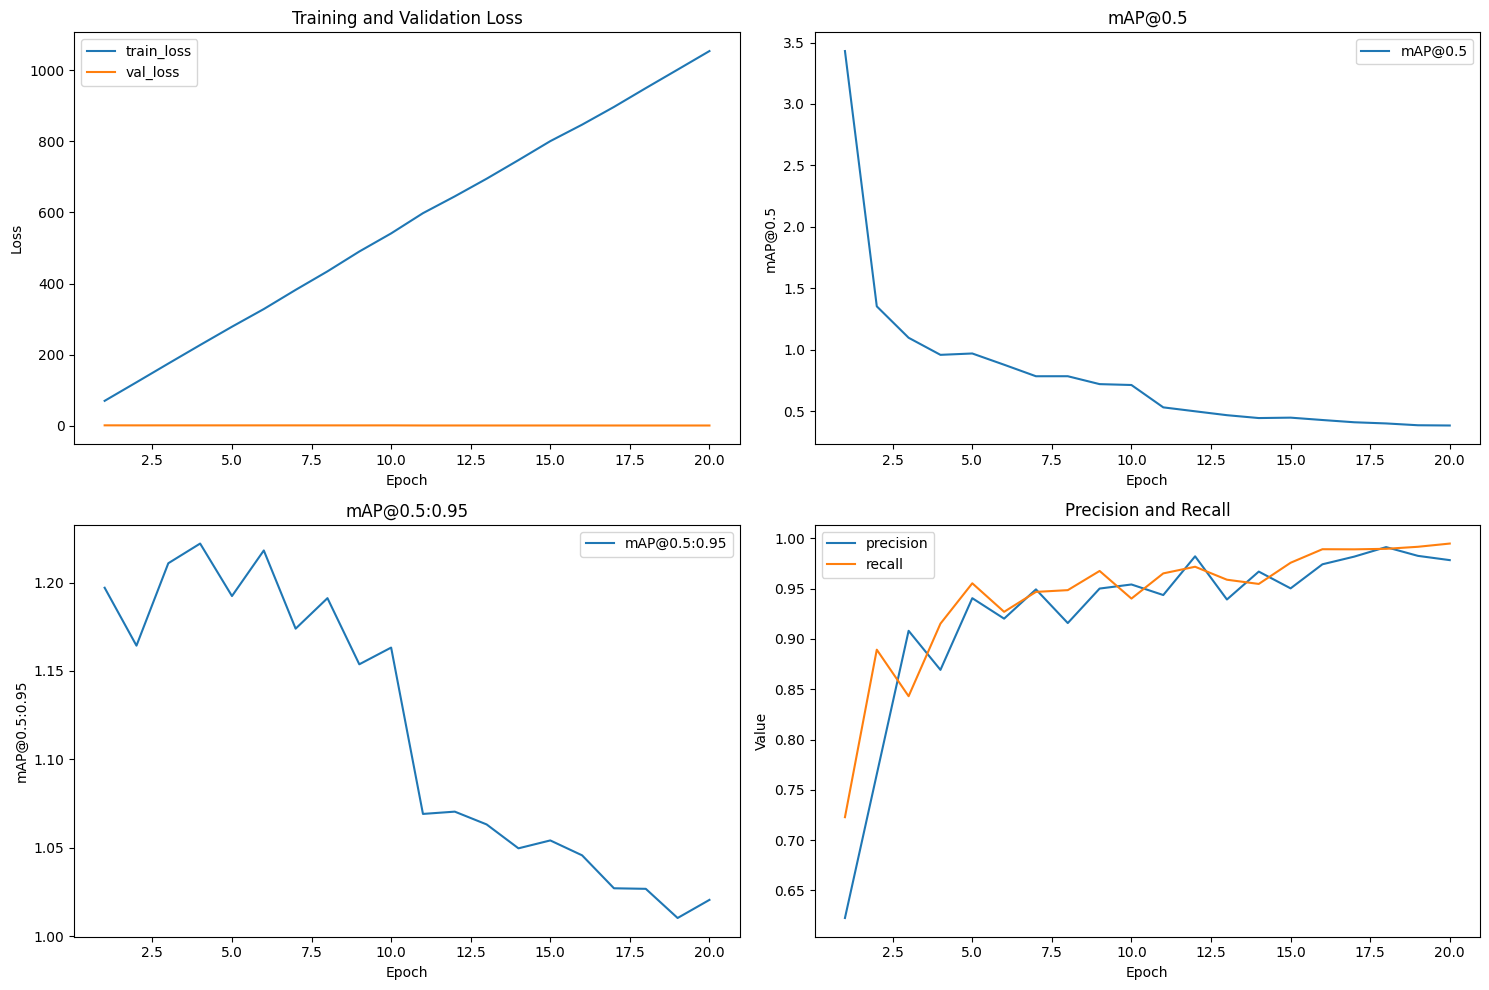

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

results_file = f"runs/detect/parasite_detection/results.csv"
if os.path.exists(results_file):
    data = np.loadtxt(results_file, delimiter=',', skiprows=1)

    plt.figure(figsize=(15, 10))

    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(data[:, 0], data[:, 1], label='train_loss')
    plt.plot(data[:, 0], data[:, 2], label='val_loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot mAP50
    plt.subplot(2, 2, 2)
    plt.plot(data[:, 0], data[:, 3], label='mAP@0.5')
    plt.title('mAP@0.5')
    plt.xlabel('Epoch')
    plt.ylabel('mAP@0.5')
    plt.legend()

    # Plot mAP50-95
    plt.subplot(2, 2, 3)
    plt.plot(data[:, 0], data[:, 4], label='mAP@0.5:0.95')
    plt.title('mAP@0.5:0.95')
    plt.xlabel('Epoch')
    plt.ylabel('mAP@0.5:0.95')
    plt.legend()

    # Plot precision and recall
    plt.subplot(2, 2, 4)
    plt.plot(data[:, 0], data[:, 5], label='precision')
    plt.plot(data[:, 0], data[:, 6], label='recall')
    plt.title('Precision and Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Inference on test set!


Running inference on Enterobius vermicularis_0611.jpg:

image 1/1 /content/yolo_dataset/images/val/Enterobius vermicularis_0611.jpg: 384x640 1 Enterobius vermicularis, 49.4ms
Speed: 2.9ms preprocess, 49.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/parasite_detection23


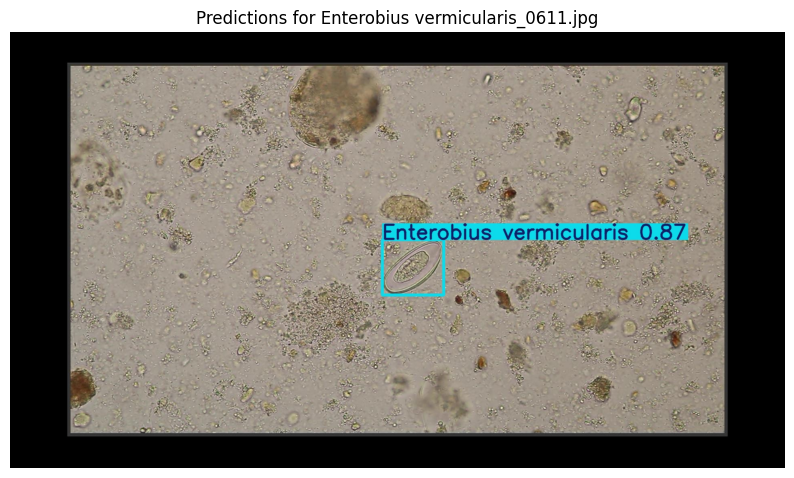

Detected: Enterobius vermicularis with confidence 0.87

Training complete! The best model weights are saved at: runs/detect/parasite_detection/weights/best.pt


In [ ]:
import os
from PIL import Image

# Select a random image from validation set for inference
val_image_dir = 'yolo_dataset/images/val'
val_images = os.listdir(val_image_dir)
random_val_image = os.path.join(val_image_dir, random.choice(val_images))

print(f"\nRunning inference on {os.path.basename(random_val_image)}:")
run_inference(random_val_image)

print("\nTraining complete! The best model weights are saved at: runs/detect/parasite_detection/weights/best.pt")

### Submit Results

The results must follows this templates

{“annotations”: [
{“id”: int,
“file_name”: str,
“category_id”: int,
“bbox”: [x,y,width,height]}
]}



```
"categories": [
        {
            "id": 0,
            "name": "Capillaria philippinensis",
        },
        {
            "id": 1,
            "name": "Enterobius vermicularis",
        },
        {
            "id": 2,
            "name": "Hymenolepis diminuta",
        },
        {
            "id": 3,
            "name": "Hymenolepis nana",
        },
        {
            "id": 4,
            "name": "Paragonimus spp",
        }
    ]
```



In [ ]:
def generate_results(model_path, test_images_dir):
    """
    Generate results in the required format:
    annotations = {"annotations": [{"id": int, "file_name": str, "category_id": int, "bbox": [x,y,width,height]}]}

    Args:
        model_path: Path to the trained model
        test_images_dir: Directory containing test images

    Returns:
        Dictionary with annotations in the required format
    """
    # Load the model
    model = YOLO(model_path)

    # Initialize annotations dictionary
    annotations = dict()
    annotations['annotations'] = list()

    # Get all image files
    image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Counter for annotation IDs
    annotation_id = 1

    # Process each image
    for img_file in image_files:
        img_path = os.path.join(test_images_dir, img_file)

        # Get image dimensions
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not read image {img_path}")
            continue

        # Run prediction
        predictions = model.predict(img_path, conf=0.25)

        # Process predictions
        for pred in predictions:
            boxes = pred.boxes

            for i, box in enumerate(boxes):
                # Get coordinates in x, y, width, height format
                x1, y1, x2, y2 = box.xyxy[0].tolist()

                # Convert to COCO format: [x, y, width, height]
                x = float(x1)
                y = float(y1)
                width = float(x2 - x1)
                height = float(y2 - y1)

                # Get category ID
                category_id = int(box.cls[0].item())

                # Add to results
                annotations['annotations'] += [{
                    "id": annotation_id,
                    "file_name": img_file,
                    "category_id": category_id,
                    "bbox": [x, y, width, height]
                }]

                annotation_id += 1

    return annotations

In [ ]:
import cv2

# Generate results
model_path = "runs/detect/parasite_detection/weights/best.pt"  # Path to your trained model
test_images_dir = "/content/parasite_test/data"  # Directory with test images

annotations = generate_results(model_path, test_images_dir)


image 1/1 /content/parasite_test/data/Paragonimus spp_0452.jpg: 640x480 1 Paragonimus spp, 50.1ms
Speed: 3.6ms preprocess, 50.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/parasite_test/data/Hymenolepis nana_0902.jpg: 640x480 1 Hymenolepis nana, 27.1ms
Speed: 3.5ms preprocess, 27.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/parasite_test/data/Capillaria philippinensis_0102.jpg: 640x480 1 Enterobius vermicularis, 27.1ms
Speed: 3.5ms preprocess, 27.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/parasite_test/data/Hymenolepis diminuta_0177.jpg: 640x480 1 Hymenolepis diminuta, 27.1ms
Speed: 3.7ms preprocess, 27.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/parasite_test/data/Enterobius vermicularis_0202.jpg: 480x640 1 Enterobius vermicularis, 51.1ms
Speed: 2.5ms preprocess, 51.1ms inference, 1.4ms postprocess per image 

In [ ]:
# annotations

In [ ]:
import requests
sendDict = { 'studentID':'6432154921', 'results':  annotations }
response = requests.post('https://www.piclab.ai/classes/cv2024/lab9/scoreboard/submitLab9',headers={'Content-Type': 'application/json' }, json=sendDict)
print(response.text)

{"F1Score":0.926841776915933,"mAP0.5":0.9317681611366713,"mAP0.5:0.95":0.7142908844557554,"mAP0.75":0.9117681611366713,"mIoU":0.7705890853012287,"status":"SUCCESS"}



In [ ]:
from google.colab import files
files.download('/content/runs/detect/parasite_detection2/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# annotations = dict()
# annotations['annotations'] = list()
# annotations['annotations'] += [{"id":2, "file_name":"Hymenolepis nana_0002.jpg","category_id":3,"bbox":[834.649658203125,
#    457.7698974609375,
#    197.173828125,
#    184.7882080078125]}]
# annotations['annotations'] += [{"id":1, "file_name":"Hymenolepis nana_0052.jpg","category_id":3,"bbox":[539.0,364.0,218.0,215.0]}]

In [ ]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

# !rm -r /content/runs